In [2]:
mydir = "/hps/nobackup/stegle/users/acuomo/all_scripts/sc_neuroseq/in_vivo_comparison/"

In [3]:
list.files(mydir)

[1] "5pct_subsample.h5ad"          "neuroseq_all_25pct_cData.Rds"
[3] "neuroseq_all_25pct_sce.Rds"   "neuroseq_all_25pct.Rds"      
[5] "SN_human_7_ind_liger.RDS"     "snigra_sce.RDS"              
[7] "snigra.seurat.Rbin"

In [4]:
neuroseq_filename = paste0(mydir,"neuroseq_all_25pct_sce.Rds")
neuroseq = readRDS(neuroseq_filename)

In [5]:
neuroseq

Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    

class: SingleCellExperiment 
dim: 32738 205416 
metadata(0):
assays(1): counts
rownames(32738): MIR1302-10 FAM138A ... AC002321.2 AC002321.1
rowData names(0):
colnames(205416): TTCCCAGGTTCCATGA-1-0 AACCGCGAGGTCATCT-1-0 ...
  GCGCAGTAGGAATGGA-1-150 GTCCTCATCTAACTTC-1-150
colData names(23): index batch ... umap1 umap2
reducedDimNames(0):
spikeNames(0):
altExpNames(0):

In [6]:
library(SingleCellExperiment)

In [7]:
# neuroseq <- normalize(neuroseq)
# design <- model.matrix(~pool_id, data = colData(neuroseq))
# alt.fit <- trendVar(neuroseq, design = design, use.spikes = FALSE)

# neuroseq = scater::logNormCounts(neuroseq)
# alt.fit <- scran::modelGeneVar(neuroseq)
# alt.decomp <- decomposeVar(neuroseq, alt.fit)

In [9]:
genes_neuroseq = as.character(rownames(neuroseq))
# genes_neuroseq = rownames(alt.decomp[order(alt.decomp$bio, decreasing = TRUE),][1:500,])

In [10]:
SN_filename = paste0(mydir,"snigra_sce.RDS")
SN = readRDS(SN_filename)

In [11]:
SN

class: SingleCellExperiment 
dim: 29445 40453 
metadata(0):
assays(1): counts
rownames(29445): A1BG A1BG-AS1 ... bP-2171C21.3 bP-2189O9.3
rowData names(0):
colnames(40453): Miami6060a_GATCGATCATACGCTA-1
  Miami6060a_GTTCATTCATATACGC-1 ... MD5862c_CCATGTCGTTCGGCAC-1
  MD5862c_CACACAACATACGCCG-1
colData names(6): nUMI nGene ... tsne1 tsne2
reducedDimNames(0):
spikeNames(0):
altExpNames(0):

In [16]:
# SN <- scater::normalize(SN)
# design <- model.matrix(~dataset, data = colData(SN))
# alt.fit <- scran::trendVar(SN, design = design, use.spikes = FALSE)
alt.decomp <- scran::decomposeVar(SN, alt.fit)

Warning message:
“'decomposeVar' is deprecated.
Use 'modelGeneVar' instead.
See help("Deprecated")”Warning message:
“'testVar' is deprecated.
See help("Deprecated")”

In [17]:
# genes_SN = rownames(SN)
genes_SN = rownames(alt.decomp[order(alt.decomp$bio, decreasing = TRUE),][1:500,])

In [18]:
# grep("NANOG",genes_SN)
grep("SOX",genes_neuroseq)

[1]  2440  2665  3269  6535  6904  9868 10364 14111 14396 14397 14818 16774
[13] 18498 20416 22227 22228 22336 24619 26290 27592 28570 29380 31976

In [19]:
###############################################
# Select common genes and subset to those only

In [20]:
common_genes = genes_neuroseq[genes_neuroseq %in% genes_SN]
length(common_genes)

[1] 487

In [21]:
neuroseq2 = neuroseq[common_genes,]
SN2 = SN[common_genes,]

In [22]:
# if (!requireNamespace("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("batchelor")

In [23]:
library(batchelor)
rescaled <- multiBatchNorm(neuroseq2, SN2)

In [24]:
neuroseq2 <- rescaled[[1]]
SN2 <- rescaled[[2]]

In [25]:
# library(scran)
# combined.dec <- combineVar(neuroseq2, SN2)
# head(combined.dec)
# chosen.hvgs <- combined.dec$bio > 0
# sum(chosen.hvgs)

In [27]:
set.seed(1000101001)
mnn.out <- fastMNN(neuroseq2, SN2, d=50, k=20, #subset.row=chosen.hvgs,
    BSPARAM=BiocSingular::RandomParam(deferred=TRUE))
mnn.out

class: SingleCellExperiment 
dim: 487 245869 
metadata(1): merge.info
assays(1): reconstructed
rownames(487): KAZN C1QC ... OLIG1 DSCAM
rowData names(1): rotation
colnames(245869): TTCCCAGGTTCCATGA-1-0 AACCGCGAGGTCATCT-1-0 ...
  MD5862c_CCATGTCGTTCGGCAC-1 MD5862c_CACACAACATACGCCG-1
colData names(1): batch
reducedDimNames(1): corrected
spikeNames(0):
altExpNames(0):

In [28]:
# str(mnn.out)

In [29]:
library(scater)
mnn.out <- runPCA(mnn.out, dimred="corrected")

Loading required package: ggplot2
Warning message in check_numbers(k = k, nu = nu, nv = nv, limit = min(dim(x)) - :
“more singular values/vectors requested than available”Warning message in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE, :
“You're computing too large a percentage of total singular values, use a standard svd instead.”

In [30]:
mnn.out

class: SingleCellExperiment 
dim: 487 245869 
metadata(1): merge.info
assays(1): reconstructed
rownames(487): KAZN C1QC ... OLIG1 DSCAM
rowData names(1): rotation
colnames(245869): TTCCCAGGTTCCATGA-1-0 AACCGCGAGGTCATCT-1-0 ...
  MD5862c_CCATGTCGTTCGGCAC-1 MD5862c_CACACAACATACGCCG-1
colData names(1): batch
reducedDimNames(2): corrected PCA
spikeNames(0):
altExpNames(0):

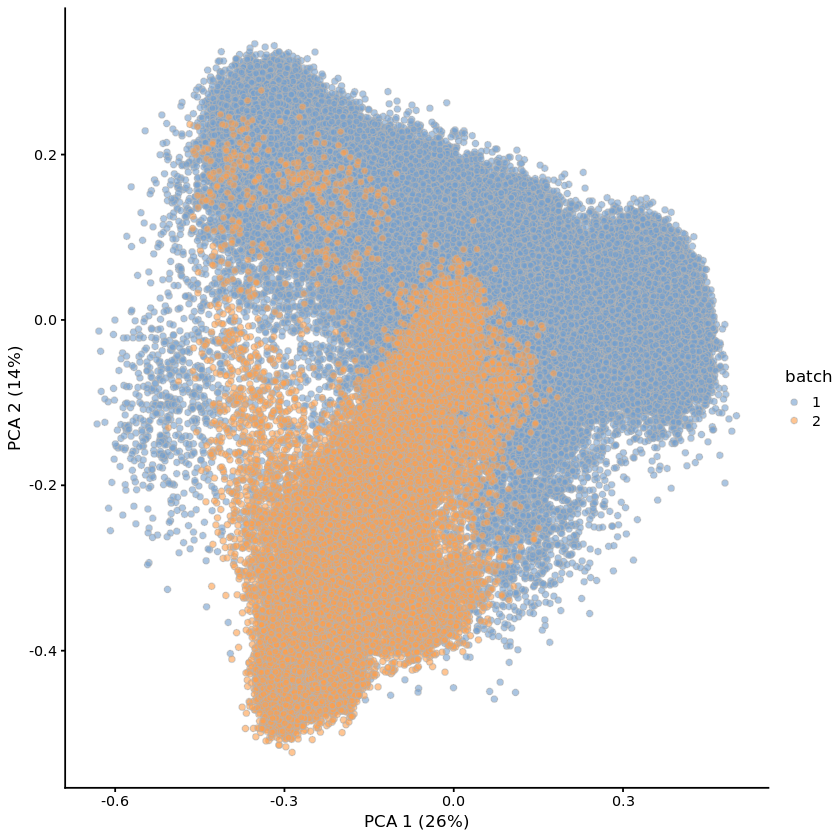

In [33]:
# mnn.out$batch <- factor(mnn.out$batch)
plotPCA(mnn.out, colour_by="batch")

In [36]:
ncol(mnn.out[,mnn.out$batch == 1])
ncol(mnn.out[,mnn.out$batch == 2])

[1] 205416

[1] 40453

In [38]:
head(colnames(mnn.out))
head(colnames(neuroseq))

[1] "TTCCCAGGTTCCATGA-1-0" "AACCGCGAGGTCATCT-1-0" "TCACAAGTCTTATCTG-1-0"
[4] "TACCTTACACGGTTTA-1-0" "CCTAGCTAGCGCCTTG-1-0" "CAAGATCAGGCTCTTA-1-0"

[1] "TTCCCAGGTTCCATGA-1-0" "AACCGCGAGGTCATCT-1-0" "TCACAAGTCTTATCTG-1-0"
[4] "TACCTTACACGGTTTA-1-0" "CCTAGCTAGCGCCTTG-1-0" "CAAGATCAGGCTCTTA-1-0"

In [ ]:
colData(mnn.out[,mnn.out$batch == 1]) <- colData(neuroseq)

In [ ]:
names(colData(mnn.out))

In [ ]:
set.seed(0010101010)
mnn.out <- runTSNE(mnn.out, dimred="corrected")
plotTSNE(mnn.out, colour_by="batch")